# Lab 6

In [1]:
# install.packages("DBI")
# install.packages("dbplyr")
# install.packages("RSQLite")  # This package takes several minutes to install! 
# install.packages("nycflights13")

In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Joins 

This section of the lab is about **joins**, which are covered in [Chapter 21 of R4DS](https://r4ds.hadley.nz/joins.html).

### Overview

In data science, we often find that related information is spread across multiple data tables. A good example of this is the data from the `nycflights13` package. As you've seen in lecture, there are actually five related tables in `nycflights13`: (1) `flights`, (2) `weather`, (3) `planes`, (4) `airlines`, and (5) `airports`.

We may want to analyze data from two, three, four, or even all five of these data frames at the same time, as this would allow us to uncover patterns and relationships that we could not observe in each one individually. For example, how are flights affected by weather? Do different airports and airlines react differently to bad weather conditions?

Fortunately, there are certain variables (i.e., **keys**) that appear in more than one of the `nycflights13` data tables and uniquely identify observations in at least one of them. We can use these variables to **join** the tables together. There are a few different types of joins — here's a hierarchy of all of them:

- Mutating joins
    - Inner joins
        - `inner_join()`
    - Outer joins
        - `full_join()`
        - `left_join()`
        - `right_join()`
- Filtering joins
    - Semi-joins
        - `semi_join()`
    - Anti-joins
        - `anti_join()`

### Load in the data

We're going to take a break from `nycflights13` in this lab. Instead, we'll work with some of the baseball data frames from the `Lahman` package:

In [3]:
# install.packages("Lahman")
library(Lahman)

We'll mostly be working with the `People`, `Batting`, and `Salaries` data frames. The documentation for the Lahman database is [here](https://cran.r-project.org/web/packages/Lahman/Lahman.pdf).

### Keys

A key is a variable that connects a pair of data frames and allows us to join them together. More specifically,

- A **primary key** is a variable (or set of variables) that uniquely identifies each observation.
    - There is at most one row in the table that corresponds to a particular value of the primary key.
    - Sometimes the observations in a table are uniquely identified by more than one variable — in this case, the set of uniquely identifying variables is called a **compound key**.
- A **foreign key** is a variable (or set of variables) that corresponds to a primary key in another table.
    - In a well-designed database, primary keys and their corresponding foreign keys have the same names.

Let's look at some examples.

In the `People` data frame, each row is uniquely identified by `playerID`, so `playerID` is a **primary key** for `People`. One way to check this is to count the number of rows in the table for each `playerID` and then filter to rows where $n > 1$. If we've correctly identified the primary key, then we will find no `playerID`s for which $n > 1$:

In [4]:
People %>%
    count(playerID) %>%
    filter(n > 1)

playerID,n
<chr>,<int>


There's also a `playerID` column in the `Batting` table. We say that `Batting$playerID` is a **foreign key** for `People$playerID` since each `playerID` in `Batting` corresponds to one `playerID` in `People`.

However, `playerID` is *not* a primary key for `Batting`. For some `playerID`s, there are multiple rows in `Batting`:

In [5]:
Batting %>%
    count(playerID) %>%
    head(10)

,playerID,n
,<chr>,<int>
1,aardsda01,9
2,aaronha01,23
3,aaronto01,7
4,aasedo01,13
5,abadan01,3
6,abadfe01,11
7,abadijo01,2
8,abbated01,10
9,abbeybe01,6


This makes sense because each row in `Batting` contains the statistics for one player in one season, and most players' careers last longer than just one season.

So what is the primary key for `Batting`? After reading through the [Lahman documentation](https://cran.r-project.org/web/packages/Lahman/Lahman.pdf), we can infer that each row in `Batting` is uniquely identified by the combination of `playerID`, `yearID`, and `stint`. These three variables form a **compound key**, and this compound key is a primary key for `Batting`:

In [6]:
Batting %>%
    count(playerID, yearID, stint) %>%
    filter(n > 1)

playerID,yearID,stint,n
<chr>,<int>,<int>,<int>


### Mutating joins

Now that we've seen how the tables in the `Lahman` database are connected by keys, we can practice using joins to actually connect them.

The first category of joins you should know about are **mutating joins**, which match observations between two data frames and then $\underline{\text{add variables}}$ from one data frame to the other. There are four types of mutating joins: (1) inner, (2) left, (3) right, and (4) full. The latter three are often called outer joins.

<img src="https://r4ds.hadley.nz/diagrams/join/venn.png" width="500" />

#### Mutating join #1: `inner_join()`

Suppose we have two data frames **x** and **y**.

**`inner_join(x, y)`** preserves all rows in **x** that have a matching key in **y**, and it adds the columns of **y** to **x**.

Let's test this out with the `Batting` and `Salaries` data frames. Note that `Batting` has 110,495 rows and 22 columns, while `Salaries` has 26,428 rows and 5 columns:

In [7]:
glimpse(Batting)
glimpse(Salaries)

Rows: 110,495
Columns: 22
$ playerID <chr> "abercda01", "addybo01", "allisar01", "allisdo01", "ansonca01…
$ yearID   <int> 1871, 1871, 1871, 1871, 1871, 1871, 1871, 1871, 1871, 1871, 1…
$ stint    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ teamID   <fct> TRO, RC1, CL1, WS3, RC1, FW1, RC1, BS1, FW1, BS1, CL1, CL1, W…
$ lgID     <fct> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ G        <int> 1, 25, 29, 27, 25, 12, 1, 31, 1, 18, 22, 1, 10, 3, 20, 29, 1,…
$ AB       <int> 4, 118, 137, 133, 120, 49, 4, 157, 5, 86, 89, 3, 36, 15, 94, …
$ R        <int> 0, 30, 28, 28, 29, 9, 0, 66, 1, 13, 18, 0, 6, 7, 24, 26, 0, 0…
$ H        <int> 0, 32, 40, 44, 39, 11, 1, 63, 1, 13, 27, 0, 7, 6, 33, 32, 0, …
$ X2B      <int> 0, 6, 4, 10, 11, 2, 0, 10, 1, 2, 1, 0, 0, 0, 9, 3, 0, 0, 1, 0…
$ X3B      <int> 0, 0, 5, 2, 3, 1, 0, 9, 0, 1, 10, 0, 0, 0, 1, 3, 0, 0, 1, 0, …
$ HR       <int> 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ RBI      <in

Note also that there are four overlapping columns between these two data frames: `yearID`, `teamID`, `lgID`, and `playerID`.

In [8]:
Batting %>%
    inner_join(Salaries)

# Equivalently:
# inner_join(Batting, Salaries)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ackerji01,1985,1,TOR,AL,61,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,170000
agostju01,1985,1,CHA,AL,54,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,147500
aguaylu01,1985,1,PHI,NL,91,165,27,46,7,⋯,1,0,22,26,5,6,4,3,7,237000
alexado01,1985,1,TOR,AL,36,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,875000
allenne01,1985,1,SLN,NL,23,2,0,0,0,⋯,0,0,0,2,0,0,0,0,0,750000
almonbi01,1985,1,PIT,NL,88,244,33,66,17,⋯,10,7,22,61,0,1,4,3,6,255000
anderla02,1985,1,PHI,NL,57,4,1,0,0,⋯,0,0,0,0,0,0,1,0,0,250500
andujjo01,1985,1,SLN,NL,38,94,2,10,2,⋯,3,1,5,50,0,0,7,0,2,1030000
armasto01,1985,1,BOS,AL,103,385,50,102,17,⋯,0,0,18,90,4,2,0,5,14,915000


The resulting table has 25,441 rows (note that this is less than the number of rows in each of the original data frames). It has 23 columns — the 22 columns in `Batting` plus the one column in `Salaries` that does not also appear in `Batting`.

Notice that the function automatically joined the two data frames by the overlapping columns listed above — this is called a **natural join**. The four overlapping columns form a compound key.

Natural joins usually give us what we want, but they don't work well if

1. A column in **x** has the same name as a column in **y** but the two columns measure something different or
2. A column in **x** measures the same thing as a column in **y** but the two columns have different names. There's an example of case (1) in [section 21.3.2](https://r4ds.hadley.nz/joins.html#specifying-join-keys) of this week's reading, and you saw an example of case (2) in Monday's lecture.

In this case, the natural join works well. To manually set the key (which is not necessary in this example), we can use the `by` argument:

In [9]:
Batting %>%
    inner_join(Salaries, by = c("playerID", "yearID", "teamID", "lgID"))

playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ackerji01,1985,1,TOR,AL,61,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,170000
agostju01,1985,1,CHA,AL,54,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,147500
aguaylu01,1985,1,PHI,NL,91,165,27,46,7,⋯,1,0,22,26,5,6,4,3,7,237000
alexado01,1985,1,TOR,AL,36,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,875000
allenne01,1985,1,SLN,NL,23,2,0,0,0,⋯,0,0,0,2,0,0,0,0,0,750000
almonbi01,1985,1,PIT,NL,88,244,33,66,17,⋯,10,7,22,61,0,1,4,3,6,255000
anderla02,1985,1,PHI,NL,57,4,1,0,0,⋯,0,0,0,0,0,0,1,0,0,250500
andujjo01,1985,1,SLN,NL,38,94,2,10,2,⋯,3,1,5,50,0,0,7,0,2,1030000
armasto01,1985,1,BOS,AL,103,385,50,102,17,⋯,0,0,18,90,4,2,0,5,14,915000


#### Mutating join #2: `left_join()`

**``left_join(x, y)``** preserves all rows in **x**, and it adds the columns of **y** to **x**.

If we do a left join of `Baseball` and `Salaries`, we get the following:

In [10]:
Batting %>%
    left_join(Salaries)

# Equivalently:
# left_join(Batting, Salaries)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
abercda01,1871,1,TRO,NA,1,4,0,0,0,⋯,0,0,0,0,NA,NA,NA,NA,0,NA
addybo01,1871,1,RC1,NA,25,118,30,32,6,⋯,8,1,4,0,NA,NA,NA,NA,0,NA
allisar01,1871,1,CL1,NA,29,137,28,40,4,⋯,3,1,2,5,NA,NA,NA,NA,1,NA
allisdo01,1871,1,WS3,NA,27,133,28,44,10,⋯,1,1,0,2,NA,NA,NA,NA,0,NA
ansonca01,1871,1,RC1,NA,25,120,29,39,11,⋯,6,2,2,1,NA,NA,NA,NA,0,NA
armstbo01,1871,1,FW1,NA,12,49,9,11,2,⋯,0,1,0,1,NA,NA,NA,NA,0,NA
barkeal01,1871,1,RC1,NA,1,4,0,1,0,⋯,0,0,1,0,NA,NA,NA,NA,0,NA
barnero01,1871,1,BS1,NA,31,157,66,63,10,⋯,11,6,13,1,NA,NA,NA,NA,1,NA
barrebi01,1871,1,FW1,NA,1,5,1,1,1,⋯,0,0,0,0,NA,NA,NA,NA,0,NA


The resulting table has 110,495 rows, which is the same number of rows as `Batting`. This makes sense, as left joins preserve all the rows in the left-hand data frame.

It also has 23 columns, just like the `inner_join()` table above. This also makes sense — we should get the same number of columns for all of these mutating joins since we are just adding the (unique) columns of `Salaries` to `Batting`.

Notice that there are a lot of `NA`s in the salary column. This is because the `Batting` table records data from 1871-2021, but according to the [Lahman documentation](https://cran.r-project.org/web/packages/Lahman/Lahman.pdf), `Salaries` only records data from 1985-2016:

In [11]:
Batting %>%
    left_join(Salaries) %>%
    group_by(yearID) %>%
    summarize(prop_NA = mean(is.na(salary))) %>%
    filter(prop_NA < 1) %>%
    pull(yearID) # List of years where at least some salaries were recorded

Joining, by = c("playerID", "yearID", "teamID", "lgID")


[1] 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
[16] 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
[31] 2015 2016

#### Mutating join #3: `right_join()`

**``right_join(x, y)``** preserves all rows in **y**, and it adds the columns of **y** to **x**.

Here's what a right join looks like for `Batting` and `Salaries`:

In [12]:
Batting %>%
    right_join(Salaries)

# Equivalently:
# right_join(Batting, Salaries)

# # Also equivalent:
# left_join(Salaries, Batting)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ackerji01,1985,1,TOR,AL,61,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,170000
agostju01,1985,1,CHA,AL,54,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,147500
aguaylu01,1985,1,PHI,NL,91,165,27,46,7,⋯,1,0,22,26,5,6,4,3,7,237000
alexado01,1985,1,TOR,AL,36,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,875000
allenne01,1985,1,SLN,NL,23,2,0,0,0,⋯,0,0,0,2,0,0,0,0,0,750000
almonbi01,1985,1,PIT,NL,88,244,33,66,17,⋯,10,7,22,61,0,1,4,3,6,255000
anderla02,1985,1,PHI,NL,57,4,1,0,0,⋯,0,0,0,0,0,0,1,0,0,250500
andujjo01,1985,1,SLN,NL,38,94,2,10,2,⋯,3,1,5,50,0,0,7,0,2,1030000
armasto01,1985,1,BOS,AL,103,385,50,102,17,⋯,0,0,18,90,4,2,0,5,14,915000


The resulting data frame has 26,437 rows, which is the same number of rows as `Salaries`. And once again, it has 23 columns.

This time, we see a lot of missing batting statistics toward the bottom of the table. This is because `Salaries` records data for both batters and pitchers, but `Batting` only records data for batters.

#### Mutating join #4: `full_join()`

**``full_join(x, y)``** preserves all rows in **x** and **y**, and it adds the columns of **y** to **x**.

In [13]:
Batting %>%
    full_join(Salaries)

# Equivalently:
# full_join(Batting, Salaries)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,salary
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
abercda01,1871,1,TRO,NA,1,4,0,0,0,⋯,0,0,0,0,NA,NA,NA,NA,0,NA
addybo01,1871,1,RC1,NA,25,118,30,32,6,⋯,8,1,4,0,NA,NA,NA,NA,0,NA
allisar01,1871,1,CL1,NA,29,137,28,40,4,⋯,3,1,2,5,NA,NA,NA,NA,1,NA
allisdo01,1871,1,WS3,NA,27,133,28,44,10,⋯,1,1,0,2,NA,NA,NA,NA,0,NA
ansonca01,1871,1,RC1,NA,25,120,29,39,11,⋯,6,2,2,1,NA,NA,NA,NA,0,NA
armstbo01,1871,1,FW1,NA,12,49,9,11,2,⋯,0,1,0,1,NA,NA,NA,NA,0,NA
barkeal01,1871,1,RC1,NA,1,4,0,1,0,⋯,0,0,1,0,NA,NA,NA,NA,0,NA
barnero01,1871,1,BS1,NA,31,157,66,63,10,⋯,11,6,13,1,NA,NA,NA,NA,1,NA
barrebi01,1871,1,FW1,NA,1,5,1,1,1,⋯,0,0,0,0,NA,NA,NA,NA,0,NA


The resulting table has 23 columns and 111,491 rows, which is more than the number of rows in either of the original data frames. More specifically, 111,491 is equal to the following:

In [14]:
26437 +       # Number of rows in left_join
    110495 -  # Number of rows in right_join
    25441     # Number of rows in inner_join

[1] 111491

### Exercise 1

**`Batting` contains single-season batting statistics for individual batters. `Salaries` contains single-season salary information for individual players. `People` contains demographic information about individual players, including their name and where they are from.**

**Using the information in these three data frames, create a scatterplot where the x-axis is `salary` and the y-axis is `HR` (home runs). Include only data from the 1998 season for batters who played at least 100 games (`G >= 100`) and who were born in either the United States (USA) or the Dominican Republic (D.R.).**

**BONUS: There are only four players in this scatterplot who hit at least 40 home runs and made at least \$7,500,000 in 1998. Can you find their first and last names?**

Joining, by = c("playerID", "yearID", "teamID", "lgID")
Joining, by = "playerID"


nameFirst,nameLast,HR,salary
<chr>,<chr>,<int>,<int>
Albert,Belle,49,10000000
Ken,Griffey,56,8153667
Mark,McGwire,70,8928354
Sammy,Sosa,66,8325000


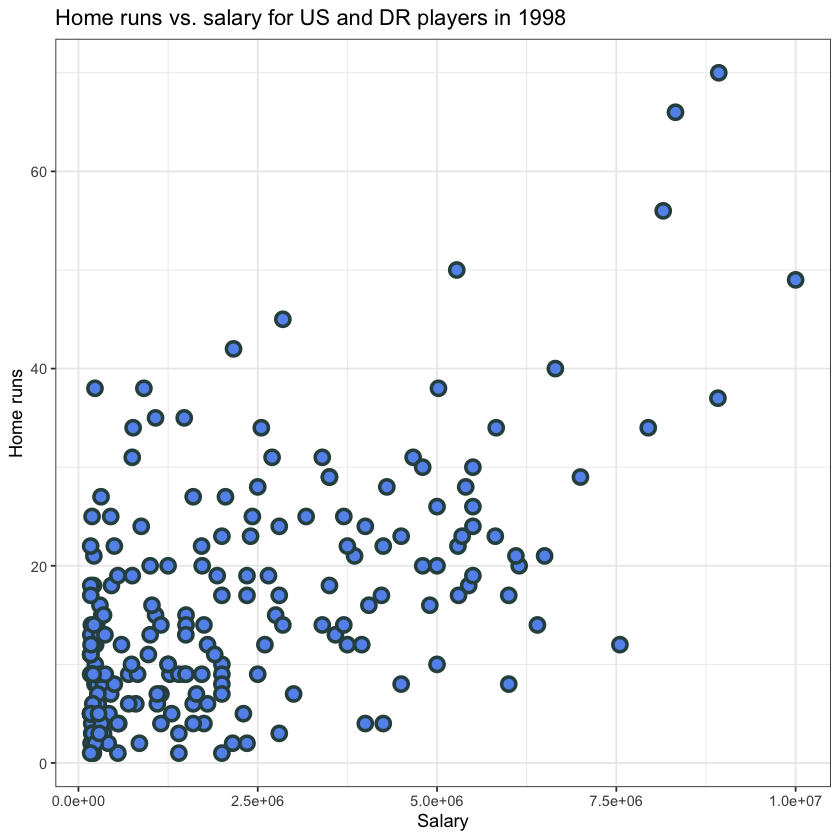

In [15]:
#@title Solution to exercise 1

table <- Batting %>%
            inner_join(Salaries) %>%
            inner_join(People) %>%
            filter(yearID == 1998, birthCountry %in% c("USA", "D.R."), G >= 100)

table %>%
    ggplot() +
    geom_point(aes(x = salary, y = HR),
                   col = "darkslategray", fill = "cornflowerblue",
                   size = 3, stroke = 1.5, shape = "circle filled") +
    theme_bw() +
    ggtitle("Home runs vs. salary for US and DR players in 1998") +
    xlab("Salary") + ylab("Home runs")

table %>% filter(salary > 7500000, HR > 40) %>% select(nameFirst, nameLast, HR, salary)

### Filtering joins

The second category of joins are **filtering joins**, which $\underline{\text{filter rows}}$ in one data frame based on whether or not they match a row in another data frame. There are two types of filtering joins: (1) semi and (2) anti.

#### Filtering join #1: `semi_join()`

**``semi_join(x, y)``** preserves all rows in **x** that have a matching key in **y**. It's kind of like an inner join except it doesn't add any of the columns from **y**.

For example, here's a semi-join for `Batting` and `Salaries`:

In [16]:
Batting %>%
    semi_join(Salaries)

# Equivalently:
# semi_join(Batting, Salaries)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ackerji01,1985,1,TOR,AL,61,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
agostju01,1985,1,CHA,AL,54,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
aguaylu01,1985,1,PHI,NL,91,165,27,46,7,⋯,21,1,0,22,26,5,6,4,3,7
alexado01,1985,1,TOR,AL,36,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
allenne01,1985,1,SLN,NL,23,2,0,0,0,⋯,0,0,0,0,2,0,0,0,0,0
almonbi01,1985,1,PIT,NL,88,244,33,66,17,⋯,29,10,7,22,61,0,1,4,3,6
anderla02,1985,1,PHI,NL,57,4,1,0,0,⋯,0,0,0,0,0,0,0,1,0,0
andujjo01,1985,1,SLN,NL,38,94,2,10,2,⋯,8,3,1,5,50,0,0,7,0,2
armasto01,1985,1,BOS,AL,103,385,50,102,17,⋯,64,0,0,18,90,4,2,0,5,14


This gives us a data frame with the same 22 columns as `Batting`, but only 25,441 rows (as opposed to the 110,495 rows in `Batting`).

#### Filtering join #2: `anti_join()`

**`anti_join(x, y)`** preserves all rows in **x** that do not have a matching key in **y**. It does not add any of the columns from **y**.

Let's try an anti-join with `Batting` and `Salaries`:

In [17]:
Batting %>%
    anti_join(Salaries)

# Equivalently:
# anti_join(Batting, Salaries)

Joining, by = c("playerID", "yearID", "teamID", "lgID")


playerID,yearID,stint,teamID,lgID,G,AB,R,H,X2B,⋯,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
<chr>,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
abercda01,1871,1,TRO,NA,1,4,0,0,0,⋯,0,0,0,0,0,NA,NA,NA,NA,0
addybo01,1871,1,RC1,NA,25,118,30,32,6,⋯,13,8,1,4,0,NA,NA,NA,NA,0
allisar01,1871,1,CL1,NA,29,137,28,40,4,⋯,19,3,1,2,5,NA,NA,NA,NA,1
allisdo01,1871,1,WS3,NA,27,133,28,44,10,⋯,27,1,1,0,2,NA,NA,NA,NA,0
ansonca01,1871,1,RC1,NA,25,120,29,39,11,⋯,16,6,2,2,1,NA,NA,NA,NA,0
armstbo01,1871,1,FW1,NA,12,49,9,11,2,⋯,5,0,1,0,1,NA,NA,NA,NA,0
barkeal01,1871,1,RC1,NA,1,4,0,1,0,⋯,2,0,0,1,0,NA,NA,NA,NA,0
barnero01,1871,1,BS1,NA,31,157,66,63,10,⋯,34,11,6,13,1,NA,NA,NA,NA,1
barrebi01,1871,1,FW1,NA,1,5,1,1,1,⋯,1,0,0,0,0,NA,NA,NA,NA,0


Similar to the semi-join from above, we get a data frame with the same 22 columns as `Batting`. However, the anti-join table has 85,054 rows. This means that 85,054 rows in `Batting` have no matching key in `Salaries`, and the remaining 25,441 rows in `Batting` have at least one matching key in `Salaries`.

### Exercise 2

**At the end of every baseball season, Gold Glove awards are handed out to the best defensive players at each position. This information, along with other awards data, is stored in the `AwardsPlayers` data frame. The following code creates a tibble of the `playerID`s of players who have won a Gold Glove since 1950:**

In [18]:
gold_gloves <- AwardsPlayers %>%
                filter(awardID == "Gold Glove", yearID >= 1950) %>%
                select(playerID)

**The `People` data frame contains demographic information about individual players, including their birth months. Filter `People` to only players who have won a Gold Glove award. What is the most common birth month of these Gold Glove winners? The least common?**

**BONUS: Filter `People` to only players who have *not* won a Gold Glove award. What is the most common birth month of these non-Gold Glove winners? The least common?**

In [19]:
#@title Solution to exercise 2

People %>%
    semi_join(gold_gloves) %>%
    filter(!is.na(birthMonth)) %>%
    group_by(birthMonth) %>%
    summarize(n = n()) %>%
    arrange(desc(n))
# Most common is April, least common is February

People %>%
    anti_join(gold_gloves) %>%
    filter(!is.na(birthMonth)) %>%
    group_by(birthMonth) %>%
    summarize(n = n()) %>%
    arrange(desc(n))
# Most common is August, least common is June

Joining, by = "playerID"


birthMonth,n
<int>,<int>
4,44
8,39
12,37
9,34
10,33
5,32
11,32
6,31
3,28


Joining, by = "playerID"


birthMonth,n
<int>,<int>
8,1909
10,1832
9,1756
1,1714
11,1685
12,1644
3,1600
7,1595
5,1531


# Databases

This section of the lab is largely based on [Chapter 23 of R4DS](https://r4ds.hadley.nz/databases.html). This chapter is a great resource if you would like to learn more about Databases! 

#### What is a Database? 

- A *Database* contains a collection of data frames (called *tables* in database terminology). 
- Much more memory efficient than a CSV file, and are used for large ammounts of data. 
- Databases are saved on hard disk rather than RAM. 

#### Why should we care? 

- Most companies store data in databases because its cheaper and more memory efficient than alternatives. 

#### Types of Databases 

- There are several types of databases including, and several different ways that one may interact with a database. 
- Popular Data Base Managing Systems (DBMS) include **PostgreSQL**, **SQL Server** and **SQLite**.
- Most DBMS use aa variation of SQL (Structured Query Language). 




For this lab, we will be using the DBMS called **RSQLite**, because this won't require any additional installations (other than `R` packages). 

#### Packages to install, if needed

In [20]:
library(DBI)  # To connect to a DB
library(dbplyr)  # To perform dplyr like operations on a DB. 


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql




### Connecting to a database

A database will often exist on your local computer or on a server that you have access to. In order to do anything with this data, we first have to **connect** with the database. 

The code below demonstrates how you might create a connection to a database using some popular DBMS: 

```
con <- DBI::dbConnect(
  RMariaDB::MariaDB(), 
  username = "foo"
)
con <- DBI::dbConnect(
  RPostgres::Postgres(), 
  hostname = "databases.mycompany.com", 
  port = 1234
)
```

The first argument is the DBMS that will be used, the following arguments are important features that you might need in order to connect to the database (i.e., username, password, location, etc.). 

**Note:** The details on how to establish a connection will change a lot from DBMS to DBMS, so you may need to do some research on how to connect to a database with your specific DBMS. 



**For this lab**, we are going to create a database using `RSQLite`. 

In [21]:
con <- DBI::dbConnect(RSQLite::SQLite())  # Connect to a new, temporary db using RSQLite
# con <- DBI::dbConnect(RSQLite::SQLite(), "my_db.sqlite")  # this version would create a new DB that isn't temporary 

dbplyr::copy_nycflights13(con)  # Copy all of the nycflights data into our temporary data base 
dbWriteTable(con, "iris", iris)  # Copy iris dataset into database 
dbWriteTable(con, "diamonds", ggplot2::diamonds)  # Copy diamonds dataset into the database

Creating table: airlines

Creating table: airports

Creating table: flights

Creating table: planes

Creating table: weather



Once we have created our database, we can check what tables are present in the database: 

In [22]:
dbListTables(con)

[1] "airlines"     "airports"     "diamonds"     "flights"      "iris"        
[6] "planes"       "sqlite_stat1" "sqlite_stat4" "weather"

While `RSQLite` enables us to do several operations on a data base, we are particularly interested as data scientists and statisticians on retrieving information from the database. This is done by using a `SELECT` statement in the SQL language, and is referred to as a **query**. 

In [23]:
SQL_query <- '
    SELECT Species, "Sepal.Length", "Sepal.Width"
    FROM iris
    WHERE "Petal.Width" > 0.8 AND "Sepal.Width" > 3.1
'

query_result <- dbGetQuery(con, SQL_query)
head(query_result)

,Species,Sepal.Length,Sepal.Width
,<chr>,<dbl>,<dbl>
1,versicolor,7.0,3.2
2,versicolor,6.4,3.2
3,versicolor,6.3,3.3
4,versicolor,5.9,3.2
5,versicolor,6.0,3.4
6,virginica,6.3,3.3


**An SQL query has 3 main components:**
- SELECT: the columns from the data.frame (or table) we want to include
- FROM: The table we want to query data from
- WHERE: any conditions we want to specify 

Other key words / operations include: 
- GROUP BY 
- ORDER BY 


**Note:** In most DBMS, the keywords are **not** case sensitive, so `select`, `fRoM`, and `WHerE` would all work. It is just standard practice to capatalize all key words to distinguish them from table names or columns. Similarly, sometimes semicolons are used, and are required by some DBMS.

Another Example: 

In [24]:
SQL_query <- '
    SELECT Species, "Sepal.Length" * "Sepal.Width" AS Sepal_Area
    FROM iris
    WHERE "Petal.Width" > 0.8 AND "Sepal.Width" > 3.1
'

query_result <- dbGetQuery(con, SQL_query)
head(query_result)

,Species,Sepal_Area
,<chr>,<dbl>
1,versicolor,22.40
2,versicolor,20.48
3,versicolor,20.79
4,versicolor,18.88
5,versicolor,20.40
6,virginica,20.79


### Exercise 3

**Using an SQL query, return a dataset containing all columns from the `flights` dataset and keep only flights from the `JFK` airport that occured in December.**

**Hint: Like other programing languages, we can use `*` as a *wild card* selector to get all columns from a dataset.**


**BONUS: Try using the ORDER BY key word to arrange the results by descending `day`**

In [25]:
#@title Solution to exercise 3

SQL_query <- '
    SELECT *
    FROM flights
    WHERE origin == \'JFK\' AND month == 12
'

query_result <- dbGetQuery(con, SQL_query)
head(query_result)


# BONUS: 
SQL_query <- '
    SELECT *
    FROM flights
    WHERE origin == \'JFK\' AND month == 12
    ORDER BY day DESC
'

query_result <- dbGetQuery(con, SQL_query)
head(query_result)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,12,1,13,2359,14,446,445,1,B6,745,N715JB,JFK,PSE,195,1617,23,59,1385956800
2,2013,12,1,17,2359,18,443,437,6,B6,839,N593JB,JFK,BQN,186,1576,23,59,1385956800
3,2013,12,1,536,540,-4,845,850,-5,AA,2243,N634AA,JFK,MIA,144,1089,5,40,1385892000
4,2013,12,1,540,550,-10,1005,1027,-22,B6,939,N821JB,JFK,BQN,189,1576,5,50,1385892000
5,2013,12,1,554,600,-6,827,849,-22,B6,353,N779JB,JFK,PBI,135,1028,6,0,1385895600
6,2013,12,1,556,600,-4,846,846,0,B6,583,N583JB,JFK,MCO,134,944,6,0,1385895600


,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013,12,31,13,2359,14,439,437,2,B6,839,N566JB,JFK,BQN,189,1576,23,59,1388548800
2,2013,12,31,18,2359,19,449,444,5,DL,412,N713TW,JFK,SJU,192,1598,23,59,1388548800
3,2013,12,31,26,2245,101,129,2353,96,B6,108,N374JB,JFK,PWM,50,273,22,45,1388545200
4,2013,12,31,554,550,4,1024,1027,-3,B6,939,N552JB,JFK,BQN,195,1576,5,50,1388484000
5,2013,12,31,555,600,-5,901,849,12,B6,353,N746JB,JFK,PBI,167,1028,6,0,1388487600
6,2013,12,31,556,600,-4,909,846,23,B6,583,N715JB,JFK,MCO,162,944,6,0,1388487600


In the example above, we see that we can modify column names and columns in the select statement. SQL is a complex language! 

**Don't panic! You don't need to learn another entire programming language for this course**. Knowing a bit of SQL can be helpful, but the `dbplyr` package will translate and perform standard `dplyr` operations like `select`, `mutate`, and `summarize` for us! 


In [26]:
large_diamonds <- tbl(con, "diamonds") %>%
   filter(price > 15000) %>%
   select(carat:clarity, price) %>%
   group_by(color) %>%
   summarize(mean_price = mean(price, na.rm = TRUE))

head(large_diamonds)

# Source:   SQL [6 x 2]
# Database: sqlite 3.40.0 []
  color mean_price
  <chr>      <dbl>
1 D         16684.
2 E         16715.
3 F         16937.
4 G         16779.
5 H         16990.
6 I         16606.

While this executes the query for us, we can also see what query was used by running the `show_query()` function: 

In [27]:
large_diamonds %>% show_query()

<SQL>
SELECT `color`, AVG(`price`) AS `mean_price`
FROM (
  SELECT `carat`, `cut`, `color`, `clarity`, `price`
  FROM `diamonds`
  WHERE (`price` > 15000.0)
)
GROUP BY `color`


In the resulting SQL query, we are using what is called a *sub query*. That is, we are selecting columns `color` and `AVG(price)` from the result of another SQL query! 

Let's check the class of the `large_diamonds` object: 

In [28]:
class(large_diamonds)

[1] "tbl_SQLiteConnection" "tbl_dbi"              "tbl_sql"             
[4] "tbl_lazy"             "tbl"

Notice that this object is still an SQL connection, not just a `data.frame` or `tbl`. Therefore if this is the data we want to work with, we should use the `collect()` function to convert it into just a `tbl`: 

In [29]:
large_diamonds %>% collect()

color,mean_price
<chr>,<dbl>
D,16683.58
E,16715.44
F,16937.06
G,16779.08
H,16989.91
I,16606.42
J,16692.74


### Exercise 4

**Use an SQL query (or `dbplyr`) to find the total number of flights and the average delay on Christmas eve or Christmas day for each airline. Display the results in order of mean delay, and then if there is a tie sort by the number of flights; only display the information for airlines that had at least 50 flights.**

In [30]:
#@title Solution to exercise 4

query <- tbl(con, "flights") %>%
    filter(month == 12 & (day == 24 | day == 25)) %>%
    group_by(carrier) %>%
    summarize(
        num_flights = n(),
        mean_delay = mean(dep_delay, na.rm = TRUE)
    ) %>%
    filter(num_flights >= 50) %>%
    arrange(mean_delay, num_flights)

query %>%
    show_query()

head(query %>% collect())

<SQL>
SELECT `carrier`, COUNT(*) AS `num_flights`, AVG(`dep_delay`) AS `mean_delay`
FROM `flights`
WHERE (`month` = 12.0 AND (`day` = 24.0 OR `day` = 25.0))
GROUP BY `carrier`
HAVING (COUNT(*) >= 50.0)
ORDER BY `mean_delay`, `num_flights`


carrier,num_flights,mean_delay
<chr>,<int>,<dbl>
US,71,1.478873
MQ,111,2.018692
B6,320,4.532915
AA,153,4.764706
DL,229,8.823009
9E,68,9.735294


### IMPORTANT! Always close your connection to the DB! 

In [31]:
dbDisconnect(con)